## Addition and Multiplication in GPT-J

### Setup

In [1]:
try:
    import google.colab
    IN_COLAB = True
    # %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    %pip install git+https://github.com/neelnanda-io/PySvelte.git
    renderer = "colab"
except:
    IN_COLAB = False
    from IPython import get_ipython
    %load_ext autoreload
    %autoreload 2
    renderer = "jupyterlab"

In [2]:
%%bash
cd ../
pip install poetry
poetry install
cd notebooks

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached urllib3-1.26.16-py2.py3-none-any.whl (143 kB)
  Using cached platformdirs-3.10.0-py3-none-any.whl (17 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.3
    Uninstalling urllib3-2.0.3:
      Successfully uninstalled urllib3-2.0.3
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 3.8.0
    Uninstalling platformdirs-3.8.0:
      Successfully uninstalled platformdirs-3.8.0
Installing dependencies from lock file

Package operations: 0 installs, 2 updates, 0 removals

  • Updating urllib3 (1.26.16 -> 2.0.3)
  • Updating platformdirs (3.10.0 -> 3.8.0)

Installing the current project: transformer-lens (0.0.0)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker 2.167.0 requires importlib-metadata<5.0,>=1.4.0, but you have importlib-metadata 5.2.0 which is incompatible.
sagemaker 2.167.0 requires protobuf<4.0,>=3.1, but you have protobuf 4.23.3 which is incompatible.
sparkmagic 0.20.5 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.5.6 which is incompatible.


In [3]:

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
pio.renderers.default = renderer


# Import stuff
import types
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import requests
import json

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
import ast
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.cm import ScalarMappable
import pickle
if IN_COLAB: 
    import pysvelte

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens.utilities import devices
from transformer_lens.past_key_value_caching import HookedTransformerKeyValueCache
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

In [4]:
import plotly.graph_objs as go

def plot_multiple_lines(y_values_list, x=None, line_names=None, title="", x_label="", y_label=""):
    traces = []
    
    if x is None: 
        x = np.arange(len(y_values_list[0]))
                             
    if line_names is None: 
        line_names = [f"Line {i}" for i in range(len(y_values_list))]
        
    for y_values, name in zip(y_values_list, line_names):
        trace = go.Scatter(x=x, y=y_values, name=name, visible=True)
        traces.append(trace)
    
    buttons = [
        {
            'args': [None, {'visible': [i == j for j in range(len(traces))]}],
            'label': name,
            'method': 'update'
        }
        for i, name in enumerate(line_names)
    ]
    
    buttons.append({
        'args': [None, {'visible': [True] * len(traces)}],
        'label': 'All',
        'method': 'update'
    })
    
    layout = go.Layout(
        title=title,
        xaxis={'title': x_label},
        yaxis={'title': y_label},
        showlegend=True,
        updatemenus=[{
            'buttons': buttons,
            'direction': 'down',
            'showactive': True,
            'x': 0.05,
            'xanchor': 'left',
            'y': 1.15,
            'yanchor': 'top'
        }]
    )
    
    fig = go.Figure(data=traces, layout=layout)
    fig.show()


def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)
def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

def cuda():
    return torch.cuda.is_available()

def get_device(): 
    return "cuda" if cuda() else "cpu"

def save_pickle(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

# Function to load a pickle object from a file
def load_pickle(filename):
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj


device = get_device()
device

'cpu'

SEED = 42
torch.set_grad_enabled(False)## Model

In [5]:
SEED = 42
torch.set_grad_enabled(False)

In [6]:
model = HookedTransformer.from_pretrained("gpt-j", device="cpu")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt-j into HookedTransformer


We investigate some preliminaries: 
- Can the model even do addition
- How are numbers tokenized
- How should we format the prompts


We find the GPT2-Large cannot do addition. 
- Weirdly it gets correct "5 + 5 =" and not "5+5=" despite tokenization properly separating terms. 
GPT2-XL doesnt seem to be much better. It gets more cases right, including some basic multiplications. However, it fails in more obscure cases. Cases which might not have naturally occured in the training data. This suggests that though GPT2 can do some basic additions, it has overfitted to a few training examples and has not actually learned addition. 
- GPT-j seems to work. All models seem to perform slightly better when few-shot prompted. 
- 10001 is the largest int represented by single token
- GPT-j can do float additions.

In [7]:
utils.test_prompt("5+5=10\n90+7=97\n15+12=", "27", model, prepend_space_to_answer=False)


Tokenized prompt: ['<|endoftext|>', '5', '+', '5', '=', '10', '\n', '90', '+', '7', '=', '97', '\n', '15', '+', '12', '=']
Tokenized answer: ['27']


Performance on answer token:
Rank: 0        Logit: 18.77 Prob: 91.91% Token: |27|

Top 0th token. Logit: 18.77 Prob: 91.91% Token: |27|
Top 1th token. Logit: 14.44 Prob:  1.21% Token: |57|
Top 2th token. Logit: 14.10 Prob:  0.86% Token: |21|
Top 3th token. Logit: 13.83 Prob:  0.66% Token: |33|
Top 4th token. Logit: 13.58 Prob:  0.51% Token: | 27|
Top 5th token. Logit: 13.37 Prob:  0.41% Token: |30|
Top 6th token. Logit: 13.32 Prob:  0.40% Token: |24|
Top 7th token. Logit: 12.95 Prob:  0.27% Token: |17|
Top 8th token. Logit: 12.93 Prob:  0.27% Token: |87|
Top 9th token. Logit: 12.81 Prob:  0.24% Token: |18|


Ranks of the answer tokens: [('27', 0)]

In [8]:
utils.test_prompt("5*5=25\n7*8=56\n12*8=", "96", model, prepend_space_to_answer=False)


Tokenized prompt: ['<|endoftext|>', '5', '*', '5', '=', '25', '\n', '7', '*', '8', '=', '56', '\n', '12', '*', '8', '=']
Tokenized answer: ['96']


Performance on answer token:
Rank: 1        Logit: 17.36 Prob: 38.77% Token: |96|

Top 0th token. Logit: 17.45 Prob: 42.44% Token: |64|
Top 1th token. Logit: 17.36 Prob: 38.77% Token: |96|
Top 2th token. Logit: 14.85 Prob:  3.16% Token: |72|
Top 3th token. Logit: 14.75 Prob:  2.86% Token: |128|
Top 4th token. Logit: 14.47 Prob:  2.16% Token: |192|
Top 5th token. Logit: 13.82 Prob:  1.13% Token: |48|
Top 6th token. Logit: 13.74 Prob:  1.04% Token: |384|
Top 7th token. Logit: 13.40 Prob:  0.74% Token: |512|
Top 8th token. Logit: 13.28 Prob:  0.66% Token: |0|
Top 9th token. Logit: 13.12 Prob:  0.56% Token: |144|


Ranks of the answer tokens: [('96', 1)]

In [9]:
model.to_str_tokens("10000")

['<|endoftext|>', '10000']

In [10]:
model.to_str_tokens("10001")

['<|endoftext|>', '100', '01']

In [11]:
model.to_str_tokens("9999")

['<|endoftext|>', '9999']

In [12]:
utils.test_prompt("5.1+5.5=10.6\n7.14+6.29=", "13.43",model, prepend_space_to_answer=False)


Tokenized prompt: ['<|endoftext|>', '5', '.', '1', '+', '5', '.', '5', '=', '10', '.', '6', '\n', '7', '.', '14', '+', '6', '.', '29', '=']
Tokenized answer: ['13', '.', '43']


Performance on answer token:
Rank: 0        Logit: 19.34 Prob: 85.02% Token: |13|

Top 0th token. Logit: 19.34 Prob: 85.02% Token: |13|
Top 1th token. Logit: 16.45 Prob:  4.72% Token: |14|
Top 2th token. Logit: 15.92 Prob:  2.78% Token: |17|
Top 3th token. Logit: 15.09 Prob:  1.21% Token: |15|
Top 4th token. Logit: 14.67 Prob:  0.79% Token: |16|
Top 5th token. Logit: 14.64 Prob:  0.77% Token: |10|
Top 6th token. Logit: 14.60 Prob:  0.74% Token: |12|
Top 7th token. Logit: 14.22 Prob:  0.51% Token: |11|
Top 8th token. Logit: 13.97 Prob:  0.39% Token: |7|
Top 9th token. Logit: 13.77 Prob:  0.32% Token: |23|


Performance on answer token:
Rank: 0        Logit: 21.81 Prob: 99.79% Token: |.|

Top 0th token. Logit: 21.81 Prob: 99.79% Token: |.|
Top 1th token. Logit: 15.22 Prob:  0.14% Token: |
|
Top 2th token. Logit: 13.69 Prob:  0.03% Token: |,|
Top 3th token. Logit: 11.49 Prob:  0.00% Token: |..|
Top 4th token. Logit: 11.04 Prob:  0.00% Token: |=|
Top 5th token. Logit: 10.98 Prob:  0.00% Token: |\.|
Top 6th token. Logit: 10.92 Prob:  0.00% Token: |+|
Top 7th token. Logit: 10.77 Prob:  0.00% Token: | |
Top 8th token. Logit: 10.69 Prob:  0.00% Token: |/|
Top 9th token. Logit: 10.62 Prob:  0.00% Token: | .|


Performance on answer token:
Rank: 0        Logit: 19.87 Prob: 63.97% Token: |43|

Top 0th token. Logit: 19.87 Prob: 63.97% Token: |43|
Top 1th token. Logit: 18.99 Prob: 26.78% Token: |53|
Top 2th token. Logit: 16.02 Prob:  1.37% Token: |42|
Top 3th token. Logit: 15.95 Prob:  1.27% Token: |93|
Top 4th token. Logit: 15.84 Prob:  1.15% Token: |63|
Top 5th token. Logit: 15.53 Prob:  0.84% Token: |52|
Top 6th token. Logit: 15.33 Prob:  0.69% Token: |33|
Top 7th token. Logit: 14.90 Prob:  0.45% Token: |03|
Top 8th token. Logit: 14.65 Prob:  0.35% Token: |73|
Top 9th token. Logit: 14.63 Prob:  0.34% Token: |51|


Ranks of the answer tokens: [('13', 0), ('.', 0), ('43', 0)]

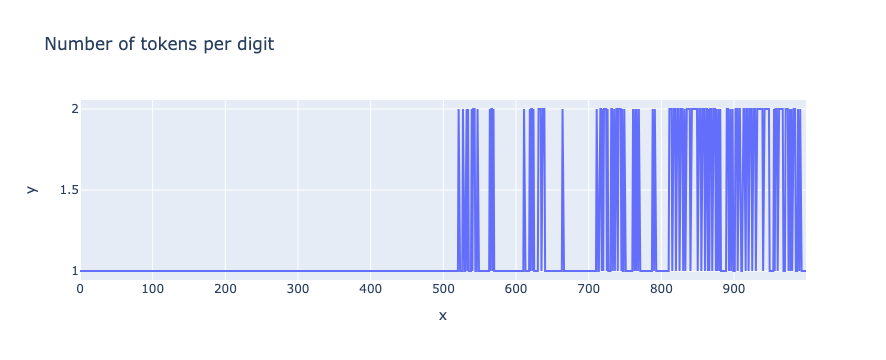

In [13]:
num_tokens_per_digit = [len(model.to_str_tokens(str(i), prepend_bos=False)) for i in range(1000)]
line(num_tokens_per_digit, title="Number of tokens per digit")

In [14]:
utils.test_prompt("Hexadecimal: 7+C=19\n8+3=", "B",model, prepend_space_to_answer=False)

Tokenized prompt: ['<|endoftext|>', 'H', 'ex', 'ade', 'c', 'imal', ':', ' 7', '+', 'C', '=', '19', '\n', '8', '+', '3', '=']
Tokenized answer: ['B']


Performance on answer token:
Rank: 10       Logit: 12.97 Prob:  0.66% Token: |B|

Top 0th token. Logit: 17.70 Prob: 75.10% Token: |11|
Top 1th token. Logit: 14.62 Prob:  3.43% Token: |19|
Top 2th token. Logit: 14.41 Prob:  2.80% Token: |C|
Top 3th token. Logit: 13.94 Prob:  1.74% Token: |1|
Top 4th token. Logit: 13.84 Prob:  1.58% Token: |13|
Top 5th token. Logit: 13.83 Prob:  1.57% Token: |5|
Top 6th token. Logit: 13.78 Prob:  1.48% Token: |7|
Top 7th token. Logit: 13.73 Prob:  1.41% Token: |21|
Top 8th token. Logit: 13.56 Prob:  1.19% Token: |17|
Top 9th token. Logit: 13.21 Prob:  0.84% Token: |3|


Ranks of the answer tokens: [('B', 10)]

Can we get any insight into how to model does addition and multiplication? Does the model use something periodic? Can the model do addition in other bases?

Tokens with lower indices usually correspond to more common words in the language, and the embeddings associated with these tokens are learned to capture their frequent patterns and meanings. As a result, during text generation, the model tends to assign higher probabilities to tokens with lower indices because they are more likely to appear in the context based on the patterns it has learned.

Here we see that the first 100 numbers, and the x50 and x00 numbers have lower token indices -> more likely by default in a bigram model. |


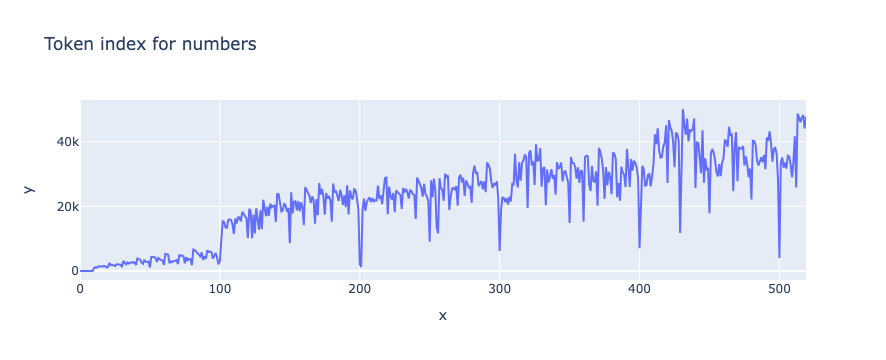

In [15]:
single_token_numbers = torch.arange(520)
number_token_index = torch.tensor([model.to_single_token(str(i)) for i in range(520)])
line(number_token_index, title="Token index for numbers")

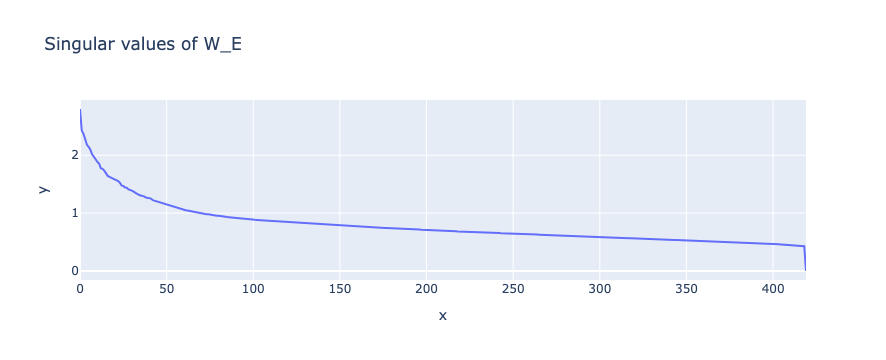

In [16]:
number_embeddings = model.W_E[number_token_index[100:]].float()
i_am_a_number = number_embeddings.mean(0)
number_embeddings_centered = number_embeddings - i_am_a_number
U, S, Vh = number_embeddings_centered.svd()
line(S, title="Singular values of W_E")
u = U[:, :20].T

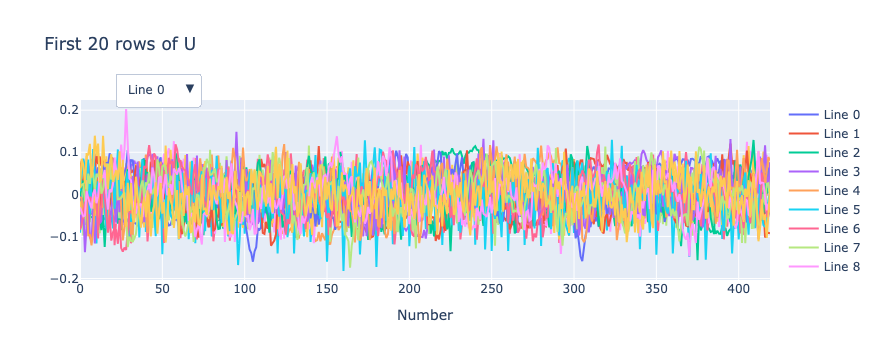

In [17]:
plot_multiple_lines(U[:, :20].T, title="First 20 rows of U", x_label="Number")


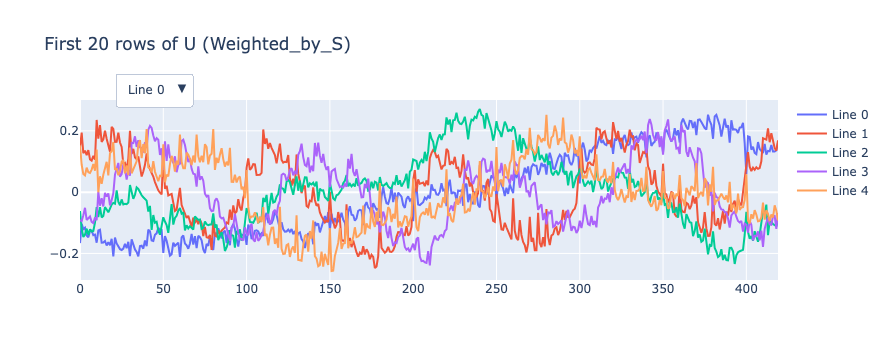

In [18]:
plot_multiple_lines((U[:, :5].T) * S[:5, None], title="First 20 rows of U (Weighted_by_S)")

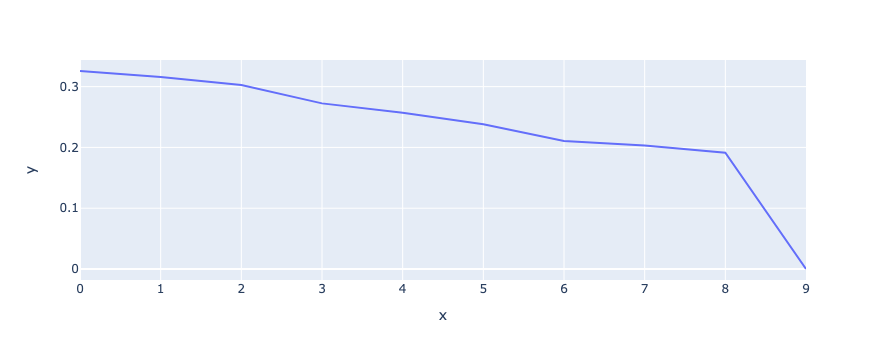

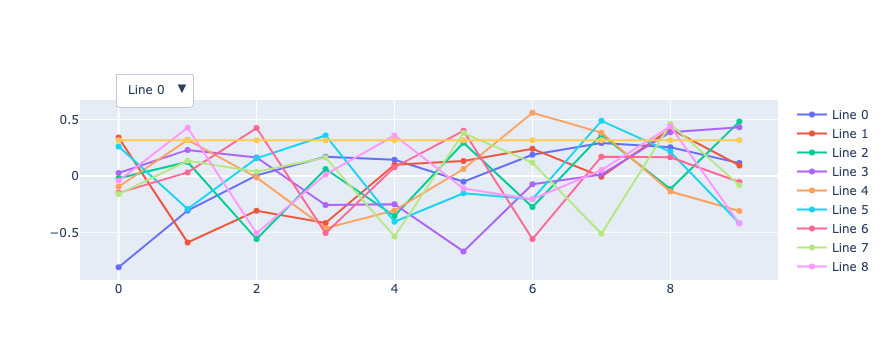

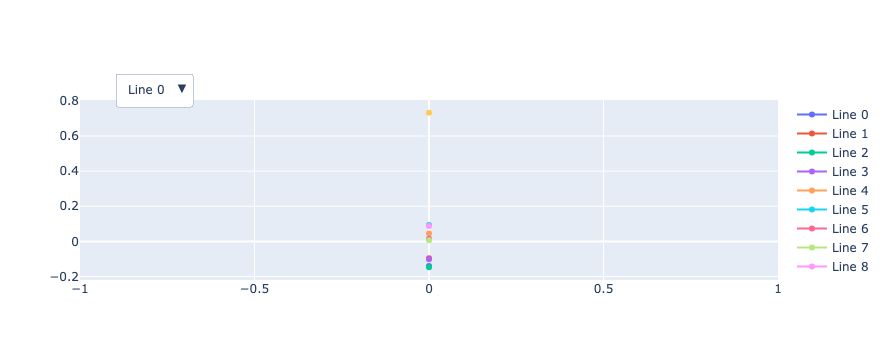

In [19]:
by_digit = einops.rearrange(number_embeddings_centered, "(other ten) d_model -> other ten d_model", ten=10)
U2, S2, Vh2 = by_digit.mean(0).svd()
line(S2)
plot_multiple_lines(U2.T)
plot_multiple_lines(U2.T @ S2[:, None])

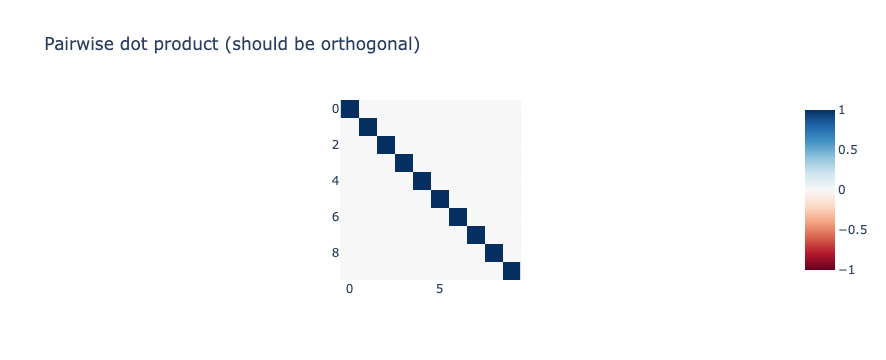

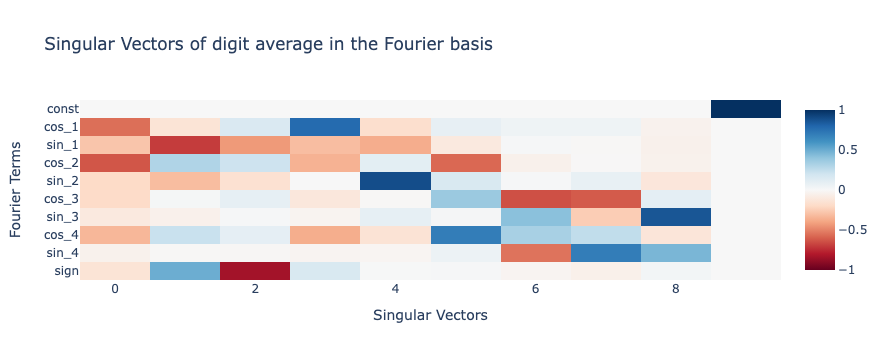

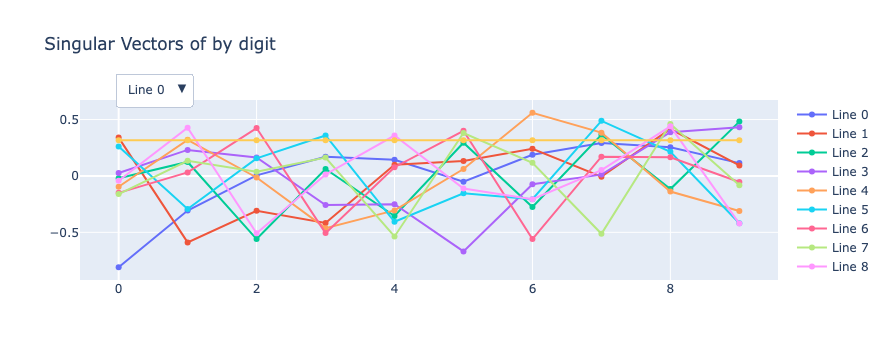

In [20]:
def fourier_basis(n):
    terms = []
    labels = []
    terms.append(torch.ones(n))
    labels.append("const")
    for i in range(1, n//2):
        terms.append(torch.cos(torch.arange(n) * 2 * torch.pi / n * i))
        terms.append(torch.sin(torch.arange(n) * 2 * torch.pi / n * i))
        labels.append(f"cos_{i}")
        labels.append(f"sin_{i}")
    if n%2 == 0:
        terms.append(torch.tensor([(1 if j%2==0 else -1) for j in range(n)]))
        labels.append(f"sign")
    terms = torch.stack(terms)
    terms = terms / terms.norm(dim=-1, keepdim=True)
    return terms, labels



fourier_terms, fourier_labels = fourier_basis(10)
imshow(fourier_terms @ fourier_terms.T, title="Pairwise dot product (should be orthogonal)")
imshow(fourier_terms @ U2, y=fourier_labels, labels={"x":"Singular Vectors", "y":"Fourier Terms"}, title="Singular Vectors of digit average in the Fourier basis")
# imshow(fourier_terms.T @ U2)
plot_multiple_lines(U2.T, title="Singular Vectors of by digit")

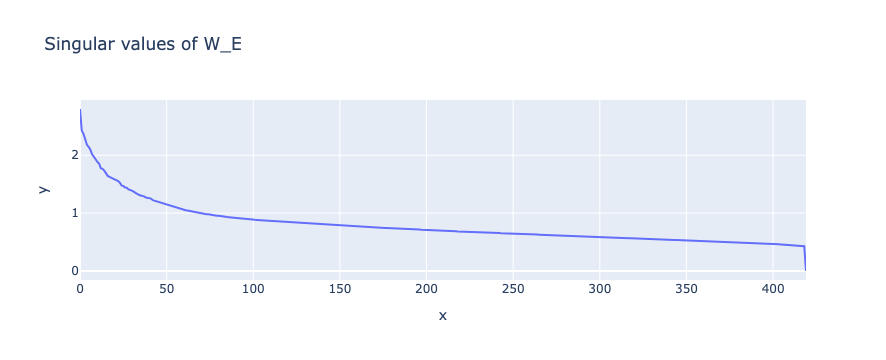

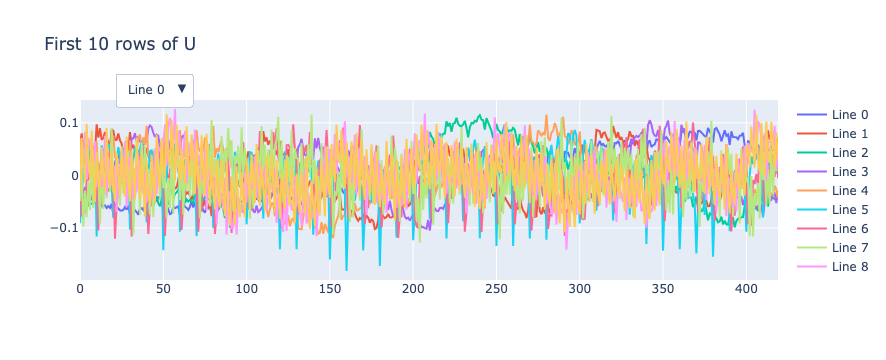

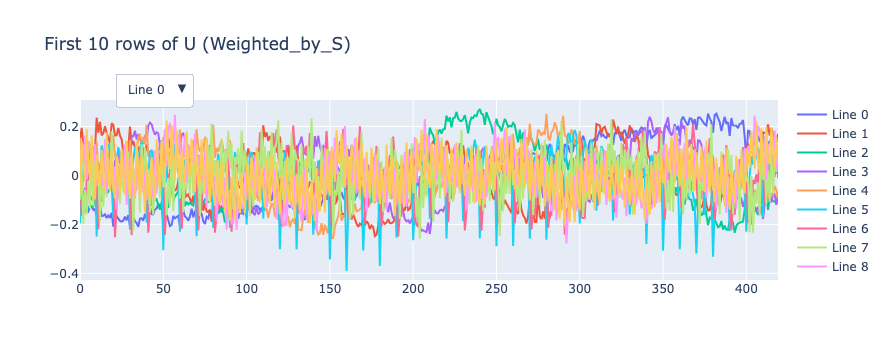

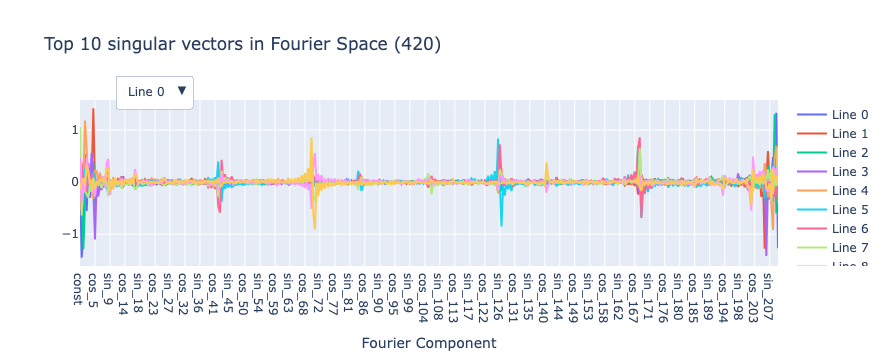

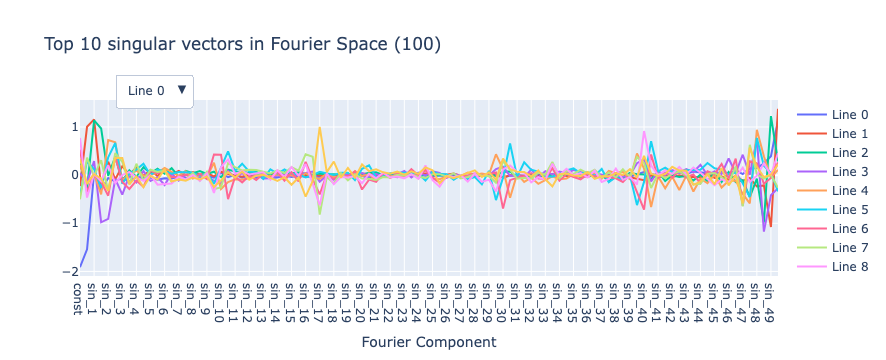

In [21]:
U, S, Vh = number_embeddings_centered.svd()
line(S, title="Singular values of W_E")
plot_multiple_lines(U[:, :10].T, title="First 10 rows of U")
plot_multiple_lines((U[:, :10].T) * S[:10, None], title="First 10 rows of U (Weighted_by_S)")
fourier_terms_420, fourier_labels_420 = fourier_basis(420)
plot_multiple_lines((U[:, :10].T @ fourier_terms_420) * S[:10, None], title="Top 10 singular vectors in Fourier Space (420)", x=fourier_labels_420, x_label="Fourier Component")

fourier_terms_100, fourier_labels_100 = fourier_basis(100)
U100, S100, Vh100 = number_embeddings_centered[:100].svd()
plot_multiple_lines((U100[:, :10].T @ fourier_terms_100) * S[:10, None], title="Top 10 singular vectors in Fourier Space (100)", x=fourier_labels_100, x_label="Fourier Component")

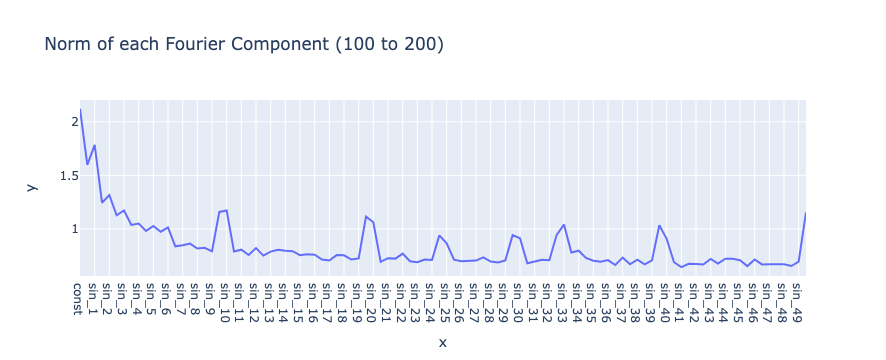

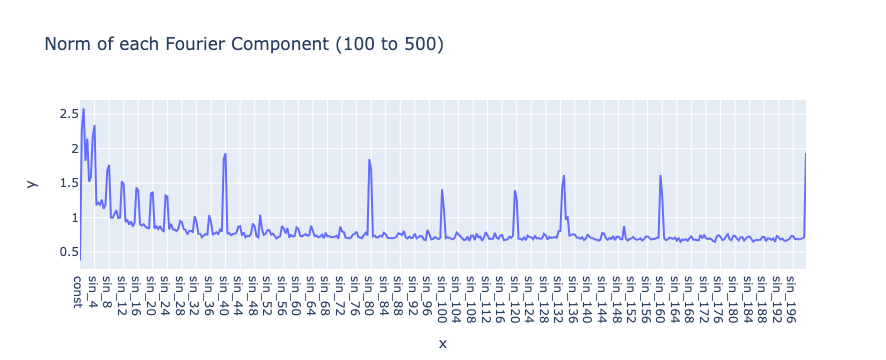

In [22]:
line((fourier_terms_100 @ number_embeddings_centered[:100]).norm(dim=-1), x=fourier_labels_100, title="Norm of each Fourier Component (100 to 200)")
fourier_terms_400, fourier_labels_400 = fourier_basis(400)

line((fourier_terms_400 @ number_embeddings_centered[:400]).norm(dim=-1), x=fourier_labels_400, title="Norm of each Fourier Component (100 to 500)")

## Few Shot Prompting

In [29]:
def make_zero_addition_shot_prompt(num_prompts=10, range_nums=(100, 200)):
    x = np.random.randint(*range_nums, size=(num_prompts))
    y = np.random.randint(*range_nums, size=(num_prompts))
    z = x+y
    prompts = [f"{x[i]}+{y[i]}=" for i in range(num_prompts)]
    answers = [f"{z[i]}" for i in range(num_prompts)]
    return prompts, answers, torch.tensor(x, device=device), torch.tensor(y, device=device), torch.tensor(z, device=device)

def make_zero_multiplication_shot_prompt(num_prompts=10, range_nums=(5, 30)):
    x = np.random.randint(*range_nums, size=(num_prompts))
    y = np.random.randint(*range_nums, size=(num_prompts))
    z = x*y
    prompts = [f"{x[i]}*{y[i]}=" for i in range(num_prompts)]
    answers = [f"{z[i]}" for i in range(num_prompts)]
    return prompts, answers, torch.tensor(x, device=device), torch.tensor(y, device=device), torch.tensor(z, device=device)


def make_n_shot_prompt(num_prompts=10, num_shots=2, range_nums=(100, 200), seed=42, task="multiplication"):
    if task=="multiplication":
        prompt_func = make_zero_multiplication_shot_prompt
    else: 
        prompt_func = make_zero_addition_shot_prompt
    
    np.random.seed(seed)
    full_prompts = [""] * num_prompts
    for i in range(num_shots):
        p, a, _, _, _ = prompt_func(num_prompts, range_nums)
        for j in range(num_prompts):
            full_prompts[j] = full_prompts[j] + f"{p[j]}{a[j]}\n"
    prompts, answers, x, y, z = prompt_func(num_prompts, range_nums)
    full_prompts = [f"{full_prompts[i]}{prompts[i]}" for i in range(num_prompts)]
    return full_prompts, prompts, answers, x, y, z

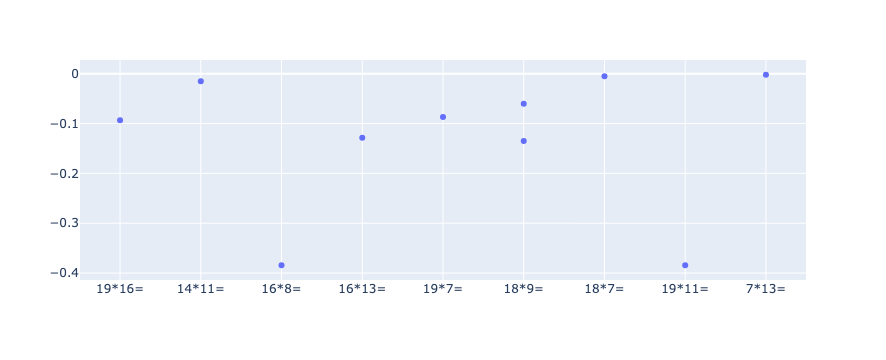

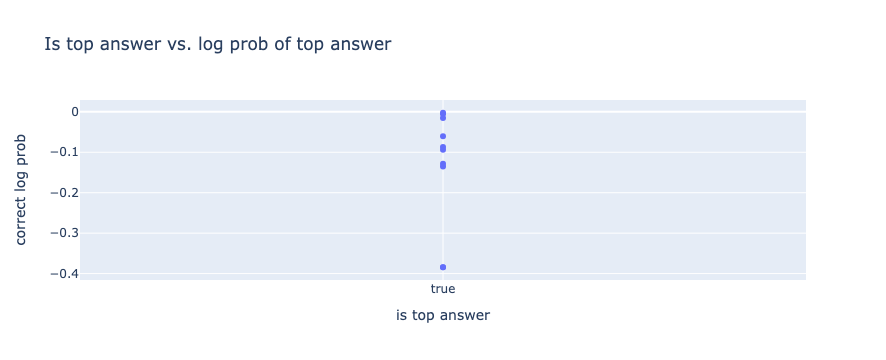

In [31]:
num_prompts = 10


num_shot = 2
full_prompts, prompts, answers, x, y, z = make_n_shot_prompt(
    num_prompts, num_shot, 
    range_nums=(5, 20), 
    task="multiplication")

tokens = model.to_tokens(full_prompts)
logits, cache = model.run_with_cache(tokens)
log_probs = logits.log_softmax(dim=-1)
answer_tokens = torch.tensor([model.to_single_token(a) for a in answers]).to(device)
plps = (log_probs[torch.arange(num_prompts).to(device), -1, answer_tokens])
scatter(y=plps, x=prompts)

is_top_answer = (log_probs[:, -1, :].argmax(dim=-1) == answer_tokens)
scatter(x=is_top_answer, y=plps, title="Is top answer vs. log prob of top answer", yaxis="correct log prob", xaxis="is top answer")


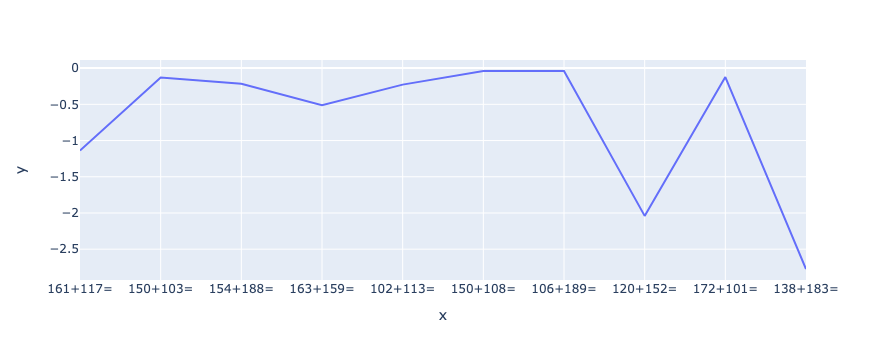

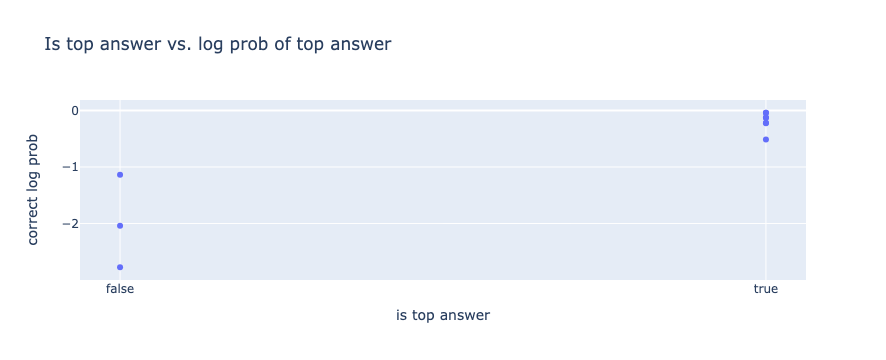

In [30]:
num_prompts = 10


num_shot = 2
full_prompts, prompts, answers, x, y, z = make_n_shot_prompt(
    num_prompts, num_shot, 
    range_nums=(100, 200), 
    task="addition")

tokens = model.to_tokens(full_prompts)
logits, cache = model.run_with_cache(tokens)
log_probs = logits.log_softmax(dim=-1)
answer_tokens = torch.tensor([model.to_single_token(a) for a in answers]).to(device)
plps = (log_probs[torch.arange(num_prompts).to(device), -1, answer_tokens])
line(plps, x=prompts)

is_top_answer = (log_probs[:, -1, :].argmax(dim=-1) == answer_tokens)
scatter(x=is_top_answer, y=plps, title="Is top answer vs. log prob of top answer", yaxis="correct log prob", xaxis="is top answer")


In [32]:
filter = is_top_answer & (plps > -0.7)
print(filter.sum())
# %%
full_prompts_filt = [i for c, i in enumerate(full_prompts) if filter[c].item()]
prompts_filt = [i for c, i in enumerate(prompts) if filter[c].item()]
answers_filt = [i for c, i in enumerate(answers) if filter[c].item()]
x_filt = [i for c, i in enumerate(x) if filter[c].item()]
y_filt = [i for c, i in enumerate(y) if filter[c].item()]
z_filt = [i for c, i in enumerate(z) if filter[c].item()]
num_prompts_filt = filter.sum()
tokens_filt = tokens[filter]
answer_tokens_filt = answer_tokens[filter]
print("tokens_filt.shape", tokens_filt.shape)

tensor(10)
tokens_filt.shape torch.Size([10, 17])


## Correlation

In [33]:
clean_tokens = tokens_filt.clone()
clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_answer = answer_tokens_filt.clone()
torch.manual_seed(SEED)


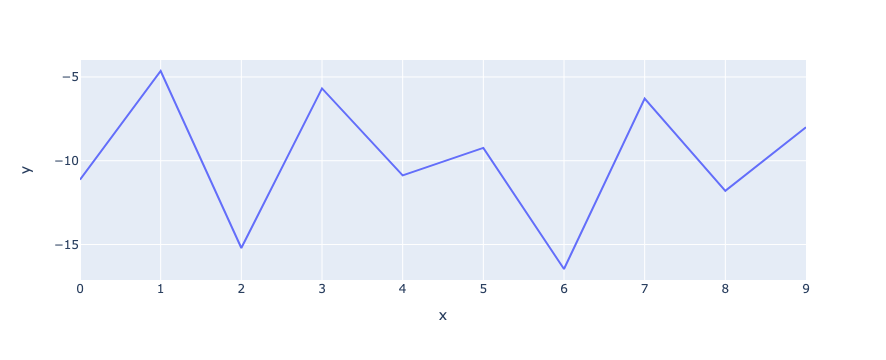

Corr X prompt 0
<|endoftext|>11*7=77
10*5=50
188*16=
Clean Prompt 0
<|endoftext|>11*7=77
10*5=50
19*16=
Corr X Answer 0
204


In [35]:
torch.manual_seed(SEED+1)
corr_x = torch.randint(100, 200, (num_prompts_filt,)).to(device)
corr_x_index = torch.tensor([model.to_single_token(str(i.item())) for i in corr_x])
corr_x_answer = torch.tensor([model.to_single_token(str(i.item() + j.item())) for i, j in zip(corr_x, y_filt)]).to(device)
corr_x_tokens = tokens_filt.clone()
X_POSITION = -4
corr_x_tokens[:, X_POSITION] = corr_x_index

corr_x_logits, corr_x_cache = model.run_with_cache(corr_x_tokens)
corr_x_log_probs = corr_x_logits.log_softmax(dim=-1)
corr_x_plps = (corr_x_log_probs[torch.arange(num_prompts_filt).to(device), -1, corr_x_answer])
line(corr_x_plps)
print("Corr X prompt 0")
print(model.to_string(corr_x_tokens[0]))
print("Clean Prompt 0")
print(model.to_string(clean_tokens[0]))
print("Corr X Answer 0")
print(model.to_string(corr_x_answer[0]))


In [36]:
torch.manual_seed(SEED+2)
corr_y = torch.randint(100, 200, (num_prompts_filt,)).to(device)
corr_y_index = torch.tensor([model.to_single_token(str(i.item())) for i in corr_y])
corr_y_answer = torch.tensor([model.to_single_token(str(i.item() + j.item())) for i, j in zip(corr_y, x_filt)]).to(device)
corr_y_tokens = tokens_filt.clone()
Y_POSITION = -2
corr_y_tokens[:, Y_POSITION] = corr_y_index

corr_y_logits, corr_y_cache = model.run_with_cache(corr_y_tokens)
corr_y_log_probs = corr_y_logits.log_softmax(dim=-1)
corr_y_plps = (corr_y_log_probs[torch.arange(num_prompts_filt).to(device), -1, corr_y_answer])
line(corr_y_plps, title="corr_y_plps")

print("Corr y prompt 0")
print(model.to_string(corr_y_tokens[0]))
print("Clean Prompt 0")
print(model.to_string(clean_tokens[0]))
print("Corr y Answer 0")
print(model.to_string(corr_y_answer[0]))

Corr y prompt 0
<|endoftext|>11*7=77
10*5=50
19*132=
Clean Prompt 0
<|endoftext|>11*7=77
10*5=50
19*16=
Corr y Answer 0
151


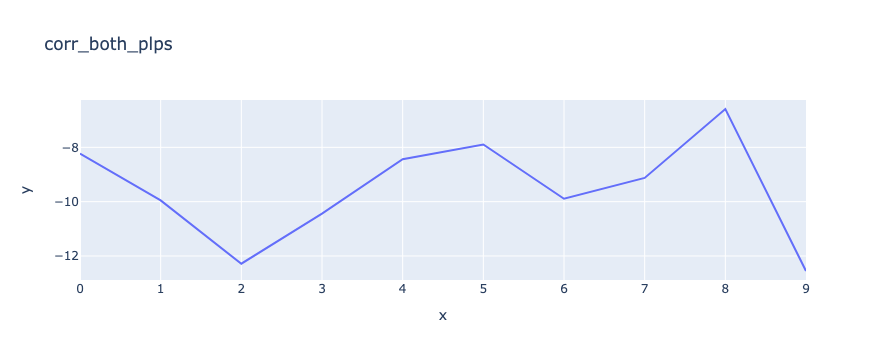

Corr both prompt 0
<|endoftext|>11*7=77
10*5=50
188*132=
Clean Prompt 0
<|endoftext|>11*7=77
10*5=50
19*16=
Corr both Answer 0
320


In [37]:
corr_both_answer = torch.tensor([model.to_single_token(str(i.item() + j.item())) for i, j in zip(corr_x, corr_y)]).to(device)
corr_both_tokens = tokens_filt.clone()
Y_POSITION = -2
corr_both_tokens[:, X_POSITION] = corr_x_index
corr_both_tokens[:, Y_POSITION] = corr_y_index

corr_both_logits, corr_both_cache = model.run_with_cache(corr_both_tokens)
corr_both_log_probs = corr_both_logits.log_softmax(dim=-1)
corr_both_plps = (corr_both_log_probs[torch.arange(num_prompts_filt).to(device), -1, corr_both_answer])
line(corr_both_plps, title="corr_both_plps")

print("Corr both prompt 0")
print(model.to_string(corr_both_tokens[0]))
print("Clean Prompt 0")
print(model.to_string(clean_tokens[0]))
print("Corr both Answer 0")
print(model.to_string(corr_both_answer[0]))

## Residual Stream Patching

In [38]:
def metric(patched_logits, per_token=False):
    patched_log_probs = patched_logits[:, -1, :].float().log_softmax(dim=-1)
    batch = len(patched_log_probs)
    plps = -patched_log_probs[torch.arange(batch, device=device), answer_tokens_filt]
    if per_token:
        return plps
    else:
        return plps.mean()
    
    
    
clean_baseline = (metric(clean_logits))
print("clean_baseline", clean_baseline)
corr_x_baseline = (metric(corr_x_logits))
print("corr_x_baseline", corr_x_baseline)
corr_y_baseline = (metric(corr_y_logits))
print("corr_y_baseline", corr_y_baseline)
corr_both_baseline = (metric(corr_both_logits))
print("corr_both_baseline", corr_both_baseline)

clean_baseline tensor(0.1296)
corr_x_baseline tensor(9.4815)
corr_y_baseline tensor(8.7663)
corr_both_baseline tensor(8.1695)


In [42]:
POS_LABELS = ["X", "+", "Y", "="]
n_layers = model.cfg.n_layers

def resid_patch_hook(resid_pre, hook, pos, layer):
    resid_pre[:, pos, :] = clean_cache["resid_pre", layer][:, pos, :]
    return resid_pre


In [ ]:
corr_x_resid_patching = torch.zeros((4, n_layers)).to(device)
for pos in range(-4, 0):
    for layer in range(n_layers):
        patched_logits = model.run_with_hooks(corr_x_tokens, fwd_hooks = [(
            utils.get_act_name("resid_pre", layer),
            partial(resid_patch_hook, pos=pos, layer=layer),)
        ])
        corr_x_resid_patching[pos, layer] = metric(patched_logits)
        
        
OFFSET_LOG_PROB = 6
imshow((OFFSET_LOG_PROB - corr_x_resid_patching),
       title="corr_x_resid_patching (6 - clean_log_prob)",
       y=POS_LABELS, yaxis="Position",
       xaxis="Layer", zmin=0, 
       zmax=OFFSET_LOG_PROB, color_continuous_scale="Blues")
       

In [ ]:
corr_y_resid_patching = torch.zeros((4, n_layers)).to(device)
for pos in range(-4, 0):
    for layer in range(n_layers):
        patched_logits = model.run_with_hooks(corr_y_tokens, fwd_hooks = [(
            utils.get_act_name("resid_pre", layer),
            partial(resid_patch_hook, pos=pos, layer=layer),)
        ])
        corr_y_resid_patching[pos, layer] = metric(patched_logits)

OFFSET_LOG_PROB = 6
imshow((OFFSET_LOG_PROB - corr_y_resid_patching),
       title="corr_y_resid_patching (6 - clean_log_prob)",
       y=POS_LABELS, yaxis="Position", xaxis="Layer",
       zmin=0, zmax=OFFSET_LOG_PROB, color_continuous_scale="Blues")

In [ ]:
corr_both_resid_patching = torch.zeros((4, n_layers)).cuda()
for pos in range(-4, 0):
    for layer in range(n_layers):
        patched_logits = model.run_with_hooks(corr_both_tokens, fwd_hooks = [(
            utils.get_act_name("resid_pre", layer),
            partial(resid_patch_hook, pos=pos, layer=layer),)
        ])
        corr_both_resid_patching[pos, layer] = metric(patched_logits)

OFFSET_LOG_PROB = 6
imshow((OFFSET_LOG_PROB - corr_both_resid_patching),
       title="corr_both_resid_patching (6 - clean_log_prob)",
       y=POS_LABELS, yaxis="Position", xaxis="Layer",
       zmin=0, zmax=OFFSET_LOG_PROB, color_continuous_scale="Blues")